# Visualize Input Features 

### This notebook visualizes the input features of the clothing transfer model used in SmartFit

### Usage: To replicate the results of this notebook, run the cells after setting up the repository and running the test example as defined in the README.

In [18]:
import numpy as np
import pickle as pkl
import scipy.io
import imageio
from PIL import Image
from matplotlib import pyplot as plt

In [4]:
!pip install imageio

## 0) Input image

/tmp/ipykernel_108041/460615216.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  pic = imageio.imread('../inputs/example_person.jpg')


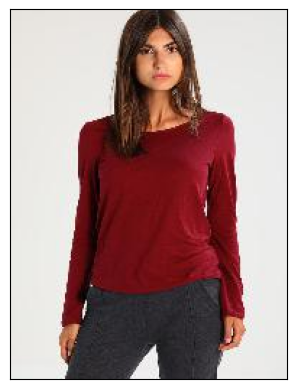

In [19]:
pic = imageio.imread('../inputs/example_person.jpg')
plt.imshow(pic)
plt.xticks([])
plt.yticks([])
plt.show()

```
Segmentation Mapping (i.e. pixel values)

0 Background, 1 Hat, 2 Hair, 3 Glove, 4 Sunglasses, 5 Upper-clothes

6 Dress, 7 Coat, 8 Socks, 9 Pants, 10 Jumpsuits, 11 Scarf

12 Skirt, 13 Face, 14 Left-arm, 15 Right-arm, 16 Left-leg, 17 Right-leg
 ```

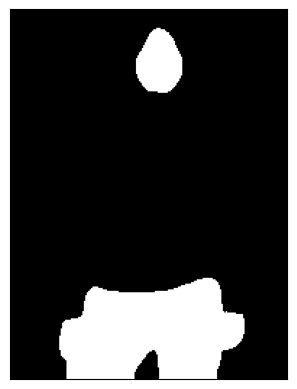

In [20]:
img = scipy.io.loadmat('../human_parsing/output/example_person.mat')
img = img['segment']
# Keep all pixels but face/hair-related items
plt.imshow(((img!=1)&(img!=2)&(img!=4)&(img!=13)&(img!=0)), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

## 2) Face and pants extraction

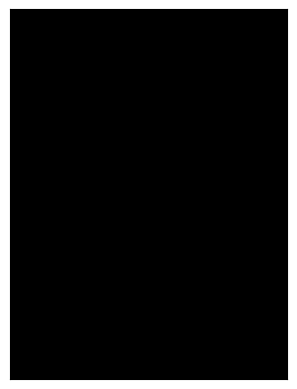

In [21]:
# Keep face/hair-related items and pants
mask = ((img==1)|(img==2)|(img==4)|(img==13)|(img==9))

plt.imshow(mask, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
################DEBUG WHY BLACK######################

In [22]:
import numpy as np
# Add this to a new cell to debug
print("Unique values in segmentation:", np.unique(img))
print("Shape of segmentation:", img.shape)
# Ensure img is a NumPy array before performing operations
if isinstance(img, dict):
	raise TypeError("The variable 'img' is a dictionary. Ensure it is a NumPy array before performing these operations.")
print("Min value:", np.min(np.array(img)))
print("Max value:", np.max(np.array(img)))

Unique values in segmentation: [  0  85 221 255]
Shape of segmentation: (256, 192)
Min value: 0
Max value: 255


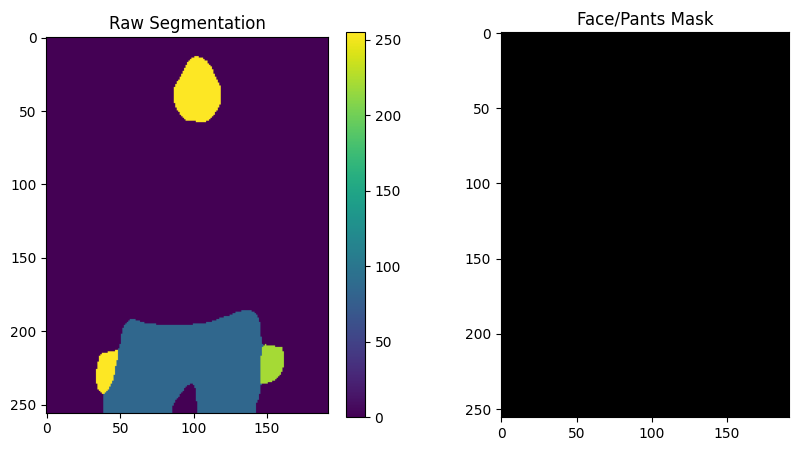

In [23]:
# Display the raw segmentation with different colormap
plt.figure(figsize=(10, 5))

# Original segmentation
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='viridis')
plt.title('Raw Segmentation')
plt.colorbar()

# Face/pants mask
plt.subplot(1, 2, 2)
mask = ((img==1)|(img==2)|(img==4)|(img==13)|(img==9))
plt.imshow(mask, cmap='gray')
plt.title('Face/Pants Mask')

plt.show()

In [24]:
# Resize in case using an image of different dimension than 256 x 192
pic = np.array(Image.fromarray(pic).resize((192, 256)))

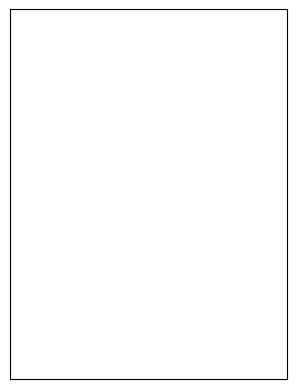

In [25]:
# Stack mask into a 3-channel image so that it can be applied to RGB images
masked_img = pic*np.stack([mask]*3, axis=2)
# Set background to white
masked_img[masked_img==0] = 255
# Plot image
plt.imshow(masked_img)
plt.xticks([])
plt.yticks([])
plt.show()

## 3) Keypoint map from the pose estimation model

```
Pose numbering correspondence

0 Nose, 1 Neck, 2 Right-shoulder, 3 Right-elbow, 4 RWrist, 5 LShoulder, 6 Left-elbow

7 Left-wrist, 8 Right-hip, 9 Right-knee, 10 Right-ankle, 11 Left-hip, 12 Left-knee 

13 Left-ankle, 14 Right-eye, 15 Left-eye, 16 Right-ear, 17 Left-ear, 18 Background
```

In [26]:
# Reads pose dictionary and returns array of keypoints
# Modified from https://github.com/xthan/VITON/blob/master/prepare_data/build_viton.py
def _extract_pose_keypoints(pose):
  pose_keypoints = - np.ones((18,2), dtype=int)
  for i in range(18):
    if pose['subset'][0,i] != -1: # If keypoint exists
      pose_keypoints[i,:] = pose['candidate'][int(pose['subset'][0,i]),:2]
  return pose_keypoints # only return the coordinates

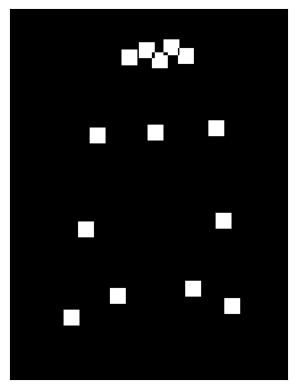

In [34]:
# Fixed version of the _extract_pose_map function
def _extract_pose_map(pose_keypoints, h, w):
    resize_h = 256.0
    resize_w = 192.0
    pose_keypoints = np.asarray(pose_keypoints, np.float32)
    pose_keypoints[:, 0] = pose_keypoints[:, 0] * resize_w / float(w)
    pose_keypoints[:, 1] = pose_keypoints[:, 1] * resize_h / float(h)
    pose_keypoints = np.asarray(pose_keypoints, np.int32)  # Changed from np.int to np.int32

    pose_map = np.zeros((int(resize_h),int(resize_w),18))
    for i in range(18):
        if pose_keypoints[i,0] < 0:
            continue
        t = np.max((pose_keypoints[i,1] - 5, 0))
        b = np.min((pose_keypoints[i,1] + 5, h - 1))
        l = np.max((pose_keypoints[i,0] - 5, 0))
        r = np.min((pose_keypoints[i,0] + 5, w - 1))
        pose_map[t:b+1, l:r+1, i] = 255
    return pose_map

# Now run the pose visualization with the fixed function
pose_dict = pkl.load(open('../pose_estimation/keras_Realtime_Multi-Person_Pose_Estimation/pose.pkl','rb'))
pose_map = _extract_pose_keypoints(pose_dict['example_person'])
pose_img = _extract_pose_map(pose_map, img.shape[0], img.shape[1])
pose_img = np.sum(pose_img, axis=2)

plt.imshow((pose_img==255), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.show()

Checking path: ../pose_estimation/keras_Realtime_Multi-Person_Pose_Estimation/pose.pkl
Found pose.pkl file!
Keys in pose_dict: ['example_person']


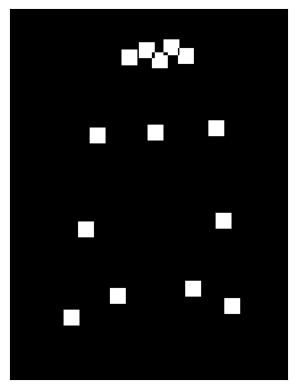

In [35]:
import os

# From the notebooks directory, we need to go up one level and then to pose_estimation
pose_pkl_path = '../pose_estimation/keras_Realtime_Multi-Person_Pose_Estimation/pose.pkl'

print("Checking path:", pose_pkl_path)

if os.path.exists(pose_pkl_path):
    print("Found pose.pkl file!")
    pose_dict = pkl.load(open(pose_pkl_path,'rb'))
    print("Keys in pose_dict:", list(pose_dict.keys()))
    
    # Extract keypoints
    pose_map = _extract_pose_keypoints(pose_dict['example_person'])
    
    # Create pose visualization
    pose_img = _extract_pose_map(pose_map, img.shape[0], img.shape[1])
    pose_img = np.sum(pose_img, axis=2)
    
    plt.imshow((pose_img==255), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.show()
else:
    print("Still not found. Let's check the directory structure:")
    print("Files in parent directory:", os.listdir('..'))

In [ ]:
# Look for pose-related files
find . -name "*.pkl" -o -name "*pose*" | head -10

## 4) Clothing Item

/tmp/ipykernel_108041/2783392625.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  top = imageio.imread('../inputs/example_clothing.jpg')


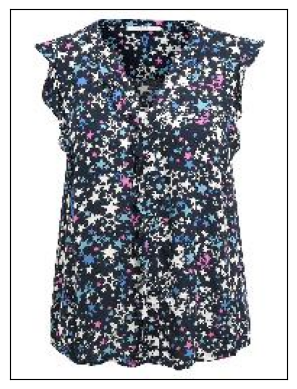

In [36]:
top = imageio.imread('../inputs/example_clothing.jpg')
plt.imshow(top)
plt.xticks([])
plt.yticks([])
plt.show()